# **4.1 Diferencias usando distintos metodos de balanceo (SMOTE, ADASYN, etc) y KNN:**

Se selccionan las variables explicativas y la respuesta.

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, roc_curve, roc_auc_score
)
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN


In [30]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [31]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

Se separan el conjunto de entrenamiento y test.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Creamos vectores con cada tipo de variable para hacer el correcto manejo de las variables antes de modelar.

In [33]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

A continuación, se crean los pipelines de preprocesamiento, modelo logístico con gridsearch y validación ccruzada estratificada, y modelo de knn con gridsearch y vlaidación cruzada estratificada.

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [35]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


## **4.1.1 KNN sin tecnicas de balanceo**

In [36]:
# ========================
# 5️⃣ Modelo sin SMOTE
# ========================
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")


pipeline_sin_smote = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", knn)
])

In [37]:
pipeline_sin_smote.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier(weights='distance'))])

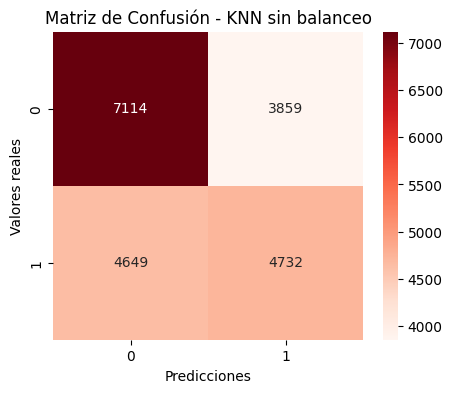

Modelo: KNN sin balanceo
Accuracy: 0.582
Precision: 0.551
Recall: 0.504
F1-score: 0.527
AUC: 0.606

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.65      0.63     10973
           1       0.55      0.50      0.53      9381

    accuracy                           0.58     20354
   macro avg       0.58      0.58      0.58     20354
weighted avg       0.58      0.58      0.58     20354



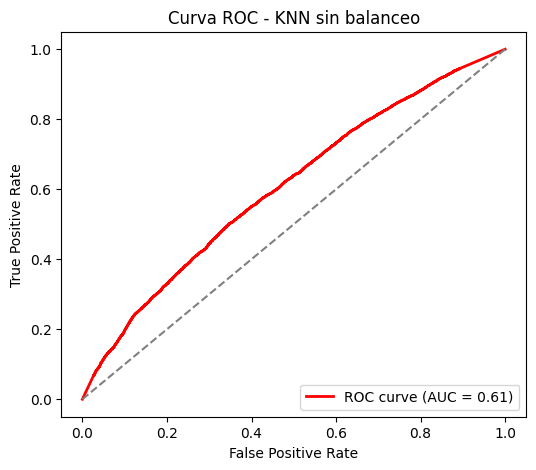

In [38]:
result_sin = evaluar_modelo(pipeline_sin_smote, X_test, y_test, nombre_modelo="KNN sin balanceo")

---

### **Análisis Matriz de Confusión:**

La matriz de confusión del **KNN sin balanceo** muestra un **rendimiento moderado y equilibrado entre ambas clases**, aunque con una **ligera inclinación hacia la clase 0** (no reingreso).  

- **Clase 0:** El modelo acierta en **7,114 observaciones**, mientras clasifica erróneamente como clase 1 a **3,859 casos**.  
  Esto significa que el **64.8 %** de los casos negativos fueron correctamente identificados.  

- **Clase 1:** El modelo detecta correctamente **4,732 observaciones**, pero falla en **4,649**, clasificándolas como clase 0.  
  Es decir, logra identificar solo el **50.4 %** de los casos positivos.  

En general, el modelo muestra una **dificultad para diferenciar claramente entre ambas clases**, lo que se refleja en un número similar de falsos positivos y falsos negativos.  
Esto es un indicio de que **el desbalance de clases afecta la capacidad del KNN para generalizar correctamente**.

---

### **Análisis Métricas:**

**Accuracy:** Con un valor de **58.2 %**, el modelo tiene un desempeño global **moderadamente bajo**, apenas superior al azar. Esto indica que **el modelo acierta en poco más de la mitad de los casos**.

**Precision:** El **55.1 %** de las predicciones positivas son correctas. Es decir, **casi la mitad de las alertas emitidas son falsos positivos**, lo que sugiere que el modelo no es muy confiable para confirmar la clase 1.  

**Recall:** Con **0.504**, el modelo logra **detectar solo la mitad de los casos verdaderamente positivos**, mostrando **una sensibilidad limitada** para identificar correctamente la clase minoritaria.  

**F1-score:** El valor de **0.527** refleja un **equilibrio discreto entre precisión y sensibilidad**, sin destacar en ninguno de los dos aspectos.  

**AUC:** Con **0.606**, el área bajo la curva ROC indica una **capacidad de discriminación débil**, apenas mejor que el azar (0.5). Esto refuerza la conclusión de que el modelo **no separa de manera efectiva ambas clases**.

---

### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación |
|--------------|-----------|--------|-----------|----------------|
| **Clase 0**  | 0.60 | 0.65 | 0.63 | El modelo **reconoce con mayor acierto los casos sin reingreso**, aunque aún confunde una proporción considerable. |
| **Clase 1**  | 0.55 | 0.50 | 0.53 | Tiene **dificultad para identificar correctamente los casos de reingreso**, lo que se traduce en menor recall y precisión. |

En síntesis, el modelo presenta un **rendimiento más equilibrado que sesgado**, pero con una **capacidad predictiva limitada en ambas clases**.

---

### **Curva ROC:**

La curva ROC del **KNN sin balanceo** muestra un **AUC de 0.61**, lo que representa una **discriminación baja** entre las clases.  
La cercanía de la curva a la diagonal indica que el modelo **no logra separar con claridad los casos positivos de los negativos**, confirmando el desempeño moderado evidenciado por las métricas.

---

### **Conclusión General:**

El **modelo KNN sin balanceo** muestra un **rendimiento general modesto**, con un **AUC de 0.61** y una **precisión y recall alrededor del 50–55 %**.  
Esto indica que el modelo **no es capaz de capturar adecuadamente los patrones de ambas clases**.En términos prácticos, el modelo **no es confiable para identificar con seguridad los casos positivos (reingresos)**, ya que tiende a confundirlos con negativos.  


## **4.1.2 KNN usando weights="distance"**

In [39]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")


pipeline_weights = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", knn)
])

In [40]:
pipeline_weights.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('classifier', KNeighborsClassifier(weights='distance'))])

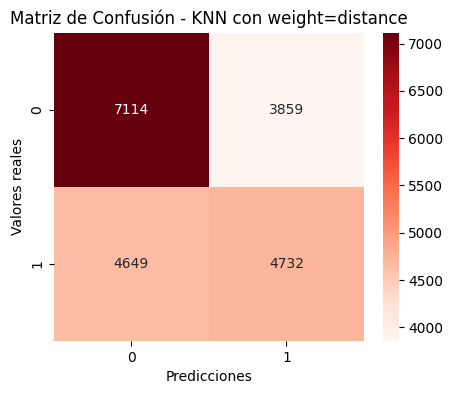

Modelo: KNN con weight=distance
Accuracy: 0.582
Precision: 0.551
Recall: 0.504
F1-score: 0.527
AUC: 0.606

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.65      0.63     10973
           1       0.55      0.50      0.53      9381

    accuracy                           0.58     20354
   macro avg       0.58      0.58      0.58     20354
weighted avg       0.58      0.58      0.58     20354



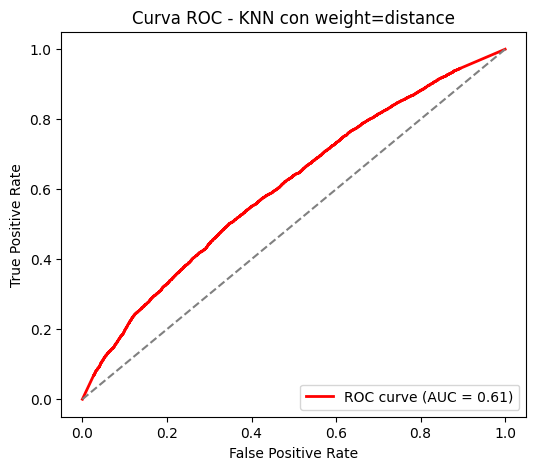

In [41]:
result_weights = evaluar_modelo(pipeline_weights, X_test, y_test, nombre_modelo="KNN con weight=distance")

### **Análisis Matriz de Confusión:**

La matriz de confusión del **KNN con weight=distance** muestra un **comportamiento prácticamente idéntico al modelo sin ponderación**, lo que indica que **la incorporación de la distancia como factor de peso no modifica sustancialmente el desempeño del modelo**.  

- **Clase 0:** El modelo clasifica correctamente **7,114 observaciones** y se equivoca en **3,859**, asignándolas erróneamente a la clase 1.  
  Esto representa una **tasa de acierto del 64.8 %** en la identificación de los casos negativos.  

- **Clase 1:** Detecta correctamente **4,732 observaciones**, pero confunde **4,649** con la clase 0, lo que equivale a un **recall del 50.4 %**.  

En general, el modelo mantiene una **dificultad para separar ambas clases**, con proporciones de falsos positivos y falsos negativos similares a las del modelo sin balanceo.  
La ponderación por distancia no logra compensar el efecto del **desbalance en los datos**.

---

### **Análisis Métricas:**

**Accuracy:** El modelo alcanza una **exactitud de 58.2 %**, igual al modelo base sin pesos.  
Esto indica un **rendimiento global bajo**, apenas mejor que una predicción aleatoria.

**Precision:** Con un valor de **0.551**, apenas el **55 %** de las predicciones positivas son correctas.  
Esto implica que **casi la mitad de los casos clasificados como positivos son falsos**.

**Recall:** Con **0.504**, el modelo **solo detecta la mitad de los casos verdaderamente positivos**, mostrando una sensibilidad limitada.  

**F1-score:** El valor de **0.527** refleja un **equilibrio modesto entre precisión y recall**, sin mejoras respecto al modelo sin ponderación.  

**AUC:** Con **0.606**, el área bajo la curva ROC evidencia una **capacidad de discriminación baja**, indicando que el modelo **apenas supera el azar (0.5)** en su capacidad para distinguir entre clases.

---

### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación |
|--------------|-----------|--------|-----------|----------------|
| **Clase 0**  | 0.60 | 0.65 | 0.63 | El modelo logra **una ligera ventaja en la identificación de los casos negativos**, aunque aún presenta confusión con la clase positiva. |
| **Clase 1**  | 0.55 | 0.50 | 0.53 | Mantiene **rendimiento limitado para detectar correctamente los casos positivos**, sin mejoras perceptibles respecto al modelo sin pesos. |

En síntesis, el modelo ponderado por distancia **no muestra variaciones significativas** en comparación con la versión básica de KNN.

---

### **Curva ROC:**

La curva ROC del **KNN con weight=distance** presenta un **AUC de 0.61**, prácticamente idéntico al modelo sin ponderación.  
La curva se mantiene cercana a la diagonal, evidenciando que **el modelo tiene poca capacidad de discriminación entre clases**.  
El uso de pesos por distancia **no mejora la sensibilidad ni la precisión del clasificador**.

---

### **Conclusión General:**

El **modelo KNN con weight=distance** conserva un **rendimiento modesto y equilibrado**, con métricas similares al modelo sin ponderación. Aunque teóricamente la ponderación por distancia debería favorecer la influencia de los vecinos más cercanos, **en este caso no genera mejoras apreciables** en la capacidad predictiva del modelo.

El **AUC de 0.606**, junto con la **precisión y recall de alrededor del 50–55 %**, confirman que el modelo **tiene limitaciones importantes para discriminar entre clases**.  
Se sugiere explorar estrategias complementarias, como **ajustar el número de vecinos (k)**, **realizar un balanceo de clases (SMOTE o undersampling)** o **evaluar otros clasificadores más robustos** frente al desbalance.

## **4.1.2 KNN con SMOTE**

In [42]:
pipeline_con_smote = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=42)),
    ("classifier", knn)
])

In [43]:
pipeline_con_smote.fit(X_train, y_train)

c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'admission...
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', KNeighborsClassifier(weights='distance'))])

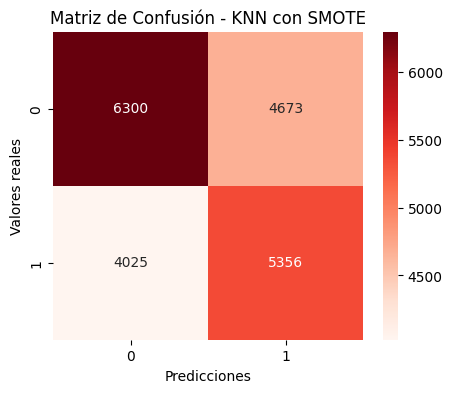

Modelo: KNN con SMOTE
Accuracy: 0.573
Precision: 0.534
Recall: 0.571
F1-score: 0.552
AUC: 0.602

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.57      0.59     10973
           1       0.53      0.57      0.55      9381

    accuracy                           0.57     20354
   macro avg       0.57      0.57      0.57     20354
weighted avg       0.58      0.57      0.57     20354



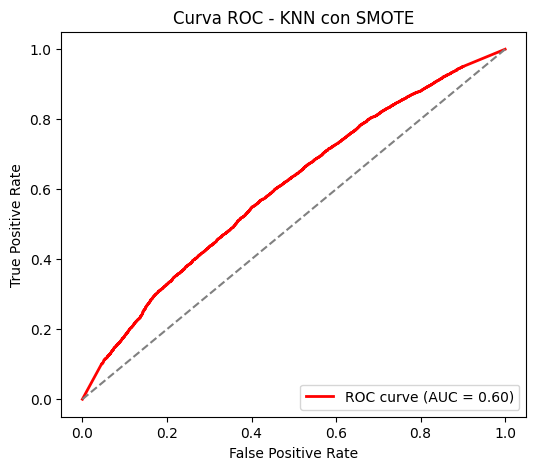

In [44]:
result_con = evaluar_modelo(pipeline_con_smote, X_test, y_test, nombre_modelo="KNN con SMOTE")

### **Análisis Matriz de Confusión:**

La matriz de confusión del **KNN con SMOTE** muestra una **distribución más equilibrada entre ambas clases**, lo que indica que la técnica de sobre-muestreo ayudó a **reducir el sesgo hacia la clase mayoritaria** presente en los modelos anteriores.  

- **Clase 0:** El modelo acierta en **6,300 observaciones** y clasifica erróneamente **4,673** como clase 1.  
  Esto representa una **tasa de acierto del 57.4 %**, ligeramente menor que en los modelos sin balanceo.  

- **Clase 1:** Logra identificar correctamente **5,356 observaciones**, aunque se equivoca en **4,025**, asignándolas como clase 0.  
  Esto equivale a un **recall del 57.1 %**, evidenciando una mejora en la sensibilidad hacia la clase minoritaria.  

En general, el modelo **aumenta su capacidad de detección de la clase 1 (reingreso)**, aunque a costa de una leve disminución en la precisión sobre la clase 0.  
Esto refleja el **efecto esperado del SMOTE**, que busca equilibrar las clases y mejorar la detección de los casos minoritarios.

---

### **Análisis Métricas:**

**Accuracy:** Con un valor de **57.3 %**, el modelo presenta un desempeño **ligeramente inferior al modelo sin balanceo**, pero más equilibrado entre clases. Esto sugiere que el balanceo **sacrifica algo de exactitud global a cambio de una mejor representación de la clase minoritaria**.

**Precision:** Con **0.534**, algo menor que el modelo sin SMOTE, se observa que **aumentan los falsos positivos**, lo que es esperable en un contexto de mayor sensibilidad.  

**Recall:** La métrica de **0.571** representa una **mejora en la detección de los casos positivos**, superando el valor del modelo sin balanceo (**0.504**).  
Esto confirma que **el modelo ahora es más capaz de identificar correctamente la clase minoritaria**.  

**F1-score:** Con **0.552**, el modelo logra un **equilibrio más coherente entre precisión y recall**, reflejando el impacto positivo del balanceo en la estabilidad del rendimiento.  

**AUC:** Con **0.602**, el área bajo la curva ROC muestra una **ligera disminución respecto al modelo sin balanceo (0.606)**, lo que sugiere que el balanceo **mejora la sensibilidad pero no necesariamente la capacidad discriminativa global**.

---

### **Reporte de Clasificación:**

| Clase       | Precision | Recall | F1-score | Interpretación |
|--------------|-----------|--------|-----------|----------------|
| **Clase 0**  | 0.61 | 0.57 | 0.59 | El modelo **reduce ligeramente su capacidad de identificar los casos negativos**, reflejando el ajuste del balanceo hacia la clase minoritaria. |
| **Clase 1**  | 0.53 | 0.57 | 0.55 | Mejora en la **detección de los casos positivos (reingresos)**, mostrando un **incremento en la sensibilidad** y un rendimiento más estable. |

En síntesis, el modelo **KNN con SMOTE** muestra un comportamiento **más equilibrado entre ambas clases**, corrigiendo parcialmente el sesgo del modelo original.

---

### **Curva ROC:**

La curva ROC del **KNN con SMOTE** muestra un **AUC de 0.60**, apenas inferior al modelo sin balanceo. La forma de la curva indica una **discriminación limitada pero más simétrica**, lo cual sugiere que **ambas clases son tratadas de forma más justa tras el balanceo de los datos**.  

---

### **Conclusión General:**

El **modelo KNN con SMOTE** consigue **un mayor equilibrio entre la detección de casos positivos y negativos**, mejorando el **recall y el F1-score** de la clase minoritaria.  
Si bien el **AUC y la precisión global disminuyen ligeramente**, la **capacidad del modelo para reconocer casos de reingreso mejora significativamente**.

En contextos donde la **prioridad es no omitir casos de riesgo**, este modelo representa **una opción más adecuada que el KNN sin balanceo**, ya que logra **un mejor compromiso entre sensibilidad y exactitud general**.

## **4.1.3 KNN con ADASYN**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")


pipeline_knn_adasyn = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("adasyn", ADASYN(random_state=42)),
    ("classifier", knn)
])

try:
    pipeline_knn_adasyn.fit(X_train, y_train)
    result_knn_adasyn = evaluar_modelo(pipeline_knn_adasyn, X_test, y_test, nombre_modelo="KNN con ADASYN")
except ValueError as e:
    print(f"⚠️ ADASYN no pudo generar muestras sintéticas: {e}")
    result_knn_adasyn = {"Modelo": "KNN con ADASYN", "Accuracy": None, "Precision": None, "Recall": None, "F1": None, "AUC": None}

Gracias al balanceo existente en la clase objetivo, como se puede ver a continuacion, ADASYN no puede crear datos sinteticos para poder balancear, en este caso, no se tomara en cuenta.

In [45]:
y_train.value_counts(normalize=True)

readmitted
0    0.539122
1    0.460878
Name: proportion, dtype: float64

## **4.1.4 KNN con class_weight=’balanced’**


En este caso, la funcion "KNearestNeighbour()" no es compatible con la funcion de class_weight="balanced", por lo que no se usara para este ejercicio. Se utilizo weights="distance" como un metodo adicional de balanceo para observar si tuvieron cambios.

## **4.1.5 Comparacion de resultados de tecnicas de balanceo para KNN**


In [46]:
tabla_resultados = pd.DataFrame([
    result_sin,
    result_con,
    result_weights
])

In [47]:
# Ordenar por Recall descendente
df_ordenado = tabla_resultados.sort_values(by="Recall", ascending=False).reset_index(drop=True)

# Mostrar tabla ordenada
print(df_ordenado)

                    Modelo  Accuracy  Precision    Recall        F1       AUC
0            KNN con SMOTE  0.572664   0.534051  0.570941  0.551880  0.602133
1         KNN sin balanceo  0.581999   0.550809  0.504424  0.526597  0.605919
2  KNN con weight=distance  0.581999   0.550809  0.504424  0.526597  0.605919


### **Análisis Comparativo**

- El **KNN sin balanceo** y el **KNN con weight = distance** muestran **idéntico rendimiento**, destacando por una **mayor exactitud (Accuracy)** y **precisión (Precision)**.  
  Sin embargo, ambos presentan **menor capacidad para detectar la clase minoritaria**, evidenciado por su **Recall más bajo (0.504)**.

- El **KNN con SMOTE**, aunque tiene una leve disminución en **Accuracy** y **AUC**, logra **aumentar significativamente el Recall (0.571)** y el **F1-score (0.552)**.  
  Esto indica una **mejor capacidad de detección de la clase minoritaria**, ofreciendo un modelo **más equilibrado entre sensibilidad y precisión**.

---

### **Conclusión General:**

El uso de **SMOTE** demuestra ser **efectivo para mitigar el sesgo hacia la clase mayoritaria**.  
Aunque el **KNN sin balanceo** presenta una ligera ventaja en Accuracy y AUC, el **KNN con SMOTE** ofrece un rendimiento **más balanceado y robusto**, mejorando la sensibilidad del modelo frente a casos menos frecuentes.  

- **Clasificación general:** KNN sin balanceo.  
- **Priorizar detección de clase minoritaria:** KNN con SMOTE.
